<h1 style="Comic Sans MS; text-align: center; color: #FFC300">SPAM Link Detection System</h1>
<p style="color: pink">We want to implement a system that is able to automatically detect whether a web page contains spam or not based on its URL using Support Vector Machines (SVM). Leveraging the power of SVM, we will train, validate, and test our model on a dataset containing labeled examples of both spam and non-spam URLs. Through rigorous experimentation and hyperparameter optimization, our goal is to create an efficient and accurate spam detection system that can effectively classify unseen URLs, thereby enhancing web security and user experience.</p>

In [94]:
import pandas as pd
import regex as re

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from pickle import dump

<h3 style="font-family: Comic Sans MS; color: #68FF33">1. Reading the dataset</h3>

In [95]:
total_data = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv')
total_data.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


<h3 style="font-family: Comic Sans MS; color: #68FF33">2. Data Processing</h3>

In [96]:
print(total_data['is_spam'].value_counts())
print('*'*50)
print(total_data.shape)

is_spam
False    2303
True      696
Name: count, dtype: int64
**************************************************
(2999, 2)


<b><span style="color: red">Categorical to numerical transformation</span></b>

In [97]:
# Using a lambda function, transform the Category column to binary where spam = 1 and no spam = 0
total_data["is_spam"] = total_data["is_spam"].apply(lambda x: 1 if x else 0).astype(int)
total_data.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


<b><span style="color: red">Check for missing values</span></b>

In [98]:
# Check if there are any missing values in the data
missing_values = total_data.isnull().sum()
missing_values

url        0
is_spam    0
dtype: int64

<b><span style="color: red">Elimination of repeated values</span></b>

In [99]:
# Eliminate duplicates if any and check the shape of the data
total_data = total_data.drop_duplicates()
total_data = total_data.reset_index(inplace=False, drop=True)
total_data.shape

(2369, 2)

In [100]:
print(f"Spam: {total_data['is_spam'].value_counts()[1]}")
print(f"Not Spam: {total_data['is_spam'].value_counts()[0]}")

Spam: 244
Not Spam: 2125


<b><span style="color: red">Text Processing</span></b>

<p style="color: pink">In order to train the model it is necessary to first apply a transformation process to the text. We start by transforming the text to lowercase and removing punctuation marks and special characters:</p>

In [101]:
def preprocess_url(url):
    # Remove any character that is not a letter (a-z) or white space ( )
    url = re.sub(r'[^a-z ]', " ", url)
    
    # Remove white spaces
    url = re.sub(r'\s+[a-zA-Z]\s+', " ", url)
    url = re.sub(r'\^[a-zA-Z]\s+', " ", url)

    # Multiple white spaces into one
    url = re.sub(r'\s+', " ", url.lower())

    # Remove tags
    url = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", url)
    
    return url.split()

total_data['url'] = total_data['url'].apply(preprocess_url)
total_data.head()

,url,is_spam
0,"[https, briefingday, us, list, manage, com, un...",1
1,"[https, www, hvper, com]",1
2,"[https, briefingday, com, v, i]",1
3,"[https, briefingday, com, m, commentform]",0
4,"[https, briefingday, com, fan]",1


<p style="color: pink">The next step is lemmatization of the text, which is the process of simplifying words to their base or canonical form, so that words with different forms but the same semantic core are treated as a single word. For example, the verbs "running", "ran" and "runs" will be lemmatized to "run", just as the words "best" and "best" could be lemmatized to "good".<br> 
<br>In addition, taking advantage of lemmatization, we will also eliminate stopwords, which are words that we consider irrelevant for text analysis because they appear very frequently in the language and do not provide meaningful information:</p>

In [102]:
download('wordnet') # WordNet is a lexical database for the English language that helps the script determine the base word
download('stopwords') # Stopwords are the English words which does not add much meaning to a sentence, they are ignored without sacrificing the meaning of the sentence (example, he, have, at...)
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

total_data['url'] = total_data['url'].apply(lemmatize_text)
total_data.head()

[nltk_data] Downloading package wordnet to C:\Users\Jorge
[nltk_data]     Payà\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Jorge
[nltk_data]     Payà\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,url,is_spam
0,"[http, briefingday, list, manage, unsubscribe]",1
1,"[http, hvper]",1
2,"[http, briefingday]",1
3,"[http, briefingday, commentform]",0
4,"[http, briefingday]",1


<p style="color: pink">Something very common once we have the tokens is to represent them in a word cloud. A word cloud is a visual representation of the words that make up a text, where the size of each word indicates its frequency or importance in the text. This visual representation allows us to quickly identify the most relevant or repeated terms or concepts in a dataset, since the most frequent or significant words stand out by their size. We can easily implement it using the wordcloud library for Python:</p>

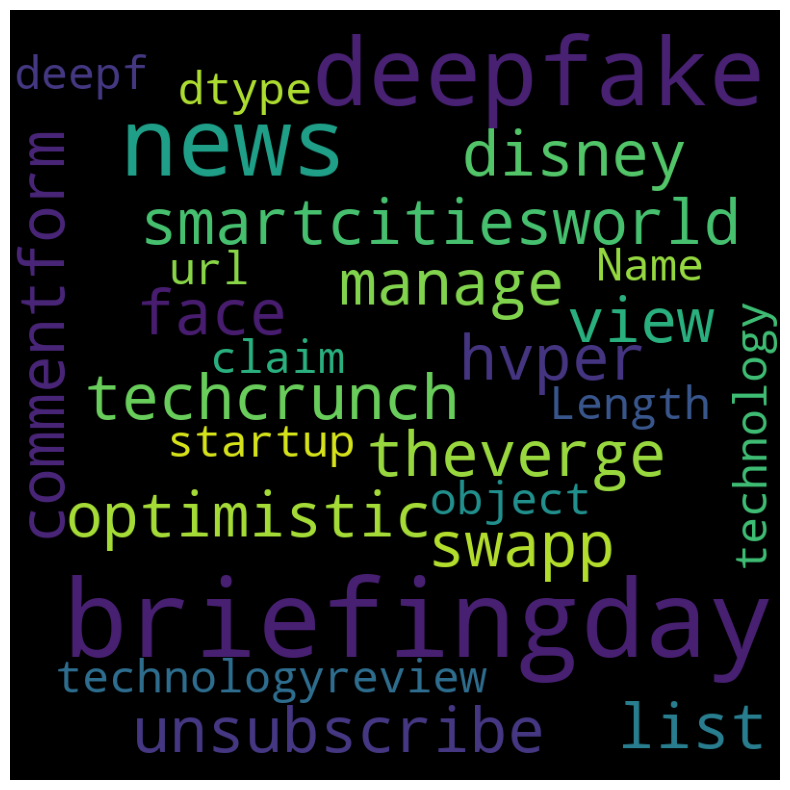

In [103]:
wordcloud = WordCloud(width = 800, height = 800, background_color = 'black', 
                      max_words = 1000, min_font_size = 20, random_state = 42).generate(str(total_data['url']))
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<p style="color: pink">The last step before training the model is to convert it into numbers, since models cannot be trained with textual categories. In previous modules we saw how we could transform text into numeric vectors using the CountVectorizer of scikit-learn, but here we will apply a new process:</p>

In [104]:
tokens_list = total_data['url']
tokens_list = [" ".join(tokens) for tokens in tokens_list]

vectorizer = TfidfVectorizer(max_features = 5000, min_df = 5, max_df = 0.8)
X = vectorizer.fit_transform(tokens_list).toarray()
y = total_data["is_spam"]
X[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<ul style="color: pink">
    <li>The <b>TfiedVectorizer</b> from <b>sklearn.feature_extraction.text</b> module to convert a collection of raw documents to a matrix of TF-IDF features. TF-IDF stands for Term Frequency-Inverse Document Frequency, a numerical statistic that reflects how important a word is to a document in a collection or corpus.</li>
    <li><b>vectorizer = TfidfVectorizer(max_features = 5000, min_df = 5, max_df = 0.8)</b>: This line is initializing a TfidfVectorizer object. The max_features parameter is set to 5000, which means that it will only consider the top 5000 terms ordered by term frequency across the corpus. The min_df parameter is set to 5 which means that a word must be included in at least 5 documents from the corpus to be considered. The max_df parameter is set to 0.8; terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words) will be ignored.</li>
    <li><b>X = vectorizer.fit_transform(tokens_list).toarray()</b>: This line is fitting the TfidfVectorizer to tokens_list and then transforming tokens_list into a TF-IDF matrix. The toarray() method is used to convert the matrix to a numpy array. This array X is the features.</li>
    <li><b>y = total_data["is_spam"]</b>: This line is extracting the 'is_spam' column from the total_data DataFrame and assigning it to y. This y is used as the target we want to predict.</li>
</ul>

<b><span style="color: red">Train test split</span></b>

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

<h3 style="font-family: Comic Sans MS; color: #68FF33">3. Initialization and training of the model</h3>

In [107]:
model = SVC(kernel = 'linear', random_state=42)
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

<h3 style="font-family: Comic Sans MS; color: #68FF33">4. Model prediction</h3>

In [108]:
y_pred = model.predict(X_test)
y_pred[:5]

array([0, 0, 1, 0, 0])

In [109]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: %.2f" % (accuracy*100), "%")

Accuracy: 95.15 %


<h3 style="font-family: Comic Sans MS; color: #68FF33">5. Save model (default)</h3>

In [110]:
dump(model, open('../models/spam_detection_svc_42.sav', 'wb'))

<div class="alert alert-block alert-success">
<b>Conclusion:</b> With the default parameters, we get a 95.15% accuracy score. Next step we are going to optimize its hyperparameters using a grid search or a random search.</div>

<h3 style="font-family: Comic Sans MS; color: #68FF33">6. Model optimization</h3>

In [111]:
# We are going to improve the model by creating a pipeline with preprocessing and hyperparameter tuning using GridSearchCV:
hyperparams = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100], # Regularization parameter
    "kernel": ["linear", "poly", "rbf", "sigmoid", "precomputed’"], # Kernel type
    "degree": [1, 2, 3, 4, 5], # Degree of the polynomial kernel function
    "gamma": ["scale", "auto"] # Kernel coefficient
}

grid_search = GridSearchCV(SVC(), hyperparams, cv = 5, scoring='accuracy')
grid_search

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'degree': [1, 2, 3, 4, 5], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid',
                                    'precomputed’']},
             scoring='accuracy')

In [112]:
grid_search.fit(X_train, y_train)

c:\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
300 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Python311\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Python311\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Python311\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validat

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'degree': [1, 2, 3, 4, 5], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid',
                                    'precomputed’']},
             scoring='accuracy')

In [115]:
print(f"Best hyperparameters: {grid_search.best_params_}")

Best hyperparameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}


In [128]:
model2 = SVC(C = 1, degree = 2, gamma = 'scale', kernel = 'poly', random_state = 42)
model2.fit(X_train, y_train)

SVC(C=1, degree=2, kernel='poly', random_state=42)

In [129]:
y_pred2 = model2.predict(X_test)
accuracy2 = accuracy_score(y_test, y_pred2)
print(f"Accuracy: %.2f" % (accuracy2*100), "%")

Accuracy: 96.41 %


In [130]:
dump(model2, open('../models/spam_detection_svc_C-1_deg-2_gam-scale_ker-poly_42.sav', 'wb'))

<div class="alert alert-block alert-success">
<b>Conclusion:</b> By adjusting the parameters to {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'} we get a 96.41% accuracy score.</div>